In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image

### Loading the dataset

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-catsvsdogs-dataset/readme[1].txt
/kaggle/input/microsoft-catsvsdogs-dataset/MSR-LA - 3467.docx
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/7981.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6234.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/1269.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3863.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6241.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10304.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/623.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2193.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11925.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3750.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11378.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2008.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10730.jpg
/kaggle/input/micros

## Prepare Dataset Directories

We create local directories for the **Cats vs Dogs dataset**:

1. **Full dataset** – copies all available images for both `Cat` and `Dog` classes into a working directory (`full_dir`).  
2. Handles broken or unreadable files by skipping them.


In [4]:
import os
import shutil
import random

# Original dataset directory
data_dir = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"

# Full dataset copy directory
full_dir = "/kaggle/working/cats_dogs_full"
os.makedirs(full_dir, exist_ok=True)

for cls in ["Cat", "Dog"]:
    src = os.path.join(data_dir, cls)
    dst = os.path.join(full_dir, cls)
    os.makedirs(dst, exist_ok=True)

    # Copy ALL files in each class
    for f in os.listdir(src):
        try:
            shutil.copy(os.path.join(src, f), os.path.join(dst, f))
        except:
            pass  # skip broken files

print("Full dataset copied to:", full_dir)

Full dataset copied to: /kaggle/working/cats_dogs_full


## Prepare Data with Augmentation and Safe Loading

1. **Data Transforms**  
   - `train_transform`: Includes data augmentation (random crop, horizontal flip, rotation, color jitter) for robust training.  
   - `val_test_transform`: Resizing and normalization for validation and test sets.

2. **Safe Loader**  
   - `SafeImageFolder` skips broken or unreadable images during loading.

3. **Dataset Splits & Loaders**  
   - Split dataset into **train (70%)**, **validation (15%)**, and **test (15%)**.  
   - Assign appropriate transforms to each split.  
   - Create PyTorch `DataLoader`s for batching and shuffling.


In [11]:
from torchvision.transforms import InterpolationMode


# 1. Data transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


# 2. Safe loader (skips broken images)

def pil_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")
    except:
        return None

class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = None
        while sample is None:
            sample = pil_loader(path)
            if sample is None:
                index = (index + 1) % len(self.samples)
                path, target = self.samples[index]
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


# 3. Dataset & loaders

dataset = SafeImageFolder(root=full_dir, transform=None)

# Define split sizes
train_size = int(0.7 * len(dataset))  # 70% train
val_size   = int(0.15 * len(dataset)) # 15% validation
test_size  = len(dataset) - train_size - val_size  # 15% test

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Assign transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = val_test_transform
test_dataset.dataset.transform  = val_test_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Training Function

We train a PyTorch image classification model and tracks performance over epochs.  

- **Training Loop:** Performs forward pass, computes loss, backpropagates gradients, and updates model parameters.
- **Validation Loop:** Evaluates the model on the validation set at the end of each epoch.
- **History Tracking:** Stores **training loss**, **validation loss**, **training accuracy**, and **validation accuracy** in a dictionary (`history`) for later visualization.
- **Device-Aware:** Automatically moves inputs and labels to the configured device (`CPU` or `GPU`).

In [12]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    # Initialize history dictionary inside the function
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        # Store train metrics
        train_acc = correct / len(train_loader.dataset)
        history["train_loss"].append(train_loss / len(train_loader))
        history["train_acc"].append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss {train_loss/len(train_loader):.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")

    # Return history dictionary at the end
    return history


# Training the Efficient_B0 model from Scratch


## EfficientNet-B0 Model for Binary Classification 

- **Model Setup:**  
  - Built **from scratch** without pretrained weights.  
  - Final classifier layer modified to output **2 classes**.  
  - Model moved to the appropriate device (`CPU` or `GPU`).  

- **Training Components:**  
  - **Loss Function:** `CrossEntropyLoss`  
  - **Optimizer:** `Adam` with learning rate `1e-4`  

- We have to note that EfficientNet-B0 is lightweight yet highly accurate, making it suitable for image classification tasks on medium-sized datasets like cats vs. dogs.


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_model(pretrained=False, num_classes=2):
    """
    Build an EfficientNet-B0 model for classification.

    Args:
        pretrained: use pretrained weights or not
        num_classes: number of output classes

    Returns:
        model: PyTorch EfficientNet-B0 on the specified device
    """
    model = models.efficientnet_b0(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    return model.to(device)

    
# Build EfficientNet-B0 from scratch (no pretrained weights)

efficientnet_model = build_model(pretrained=False, num_classes=2)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(efficientnet_model.parameters(), lr=1e-4)

In [18]:
history = train_model(efficientnet_model, train_loader, val_loader, optimizer, criterion, epochs=10)

Epoch 1: Train Loss 0.3724, Train Acc 0.8843, Val Acc 0.9467
Epoch 2: Train Loss 0.2108, Train Acc 0.9380, Val Acc 0.9563
Epoch 3: Train Loss 0.1770, Train Acc 0.9405, Val Acc 0.9592
Epoch 4: Train Loss 0.1533, Train Acc 0.9466, Val Acc 0.9611
Epoch 5: Train Loss 0.1432, Train Acc 0.9486, Val Acc 0.9635
Epoch 6: Train Loss 0.1381, Train Acc 0.9499, Val Acc 0.9608
Epoch 7: Train Loss 0.1313, Train Acc 0.9500, Val Acc 0.9643
Epoch 8: Train Loss 0.1311, Train Acc 0.9517, Val Acc 0.9629
Epoch 9: Train Loss 0.1258, Train Acc 0.9538, Val Acc 0.9664
Epoch 10: Train Loss 0.1261, Train Acc 0.9531, Val Acc 0.9653


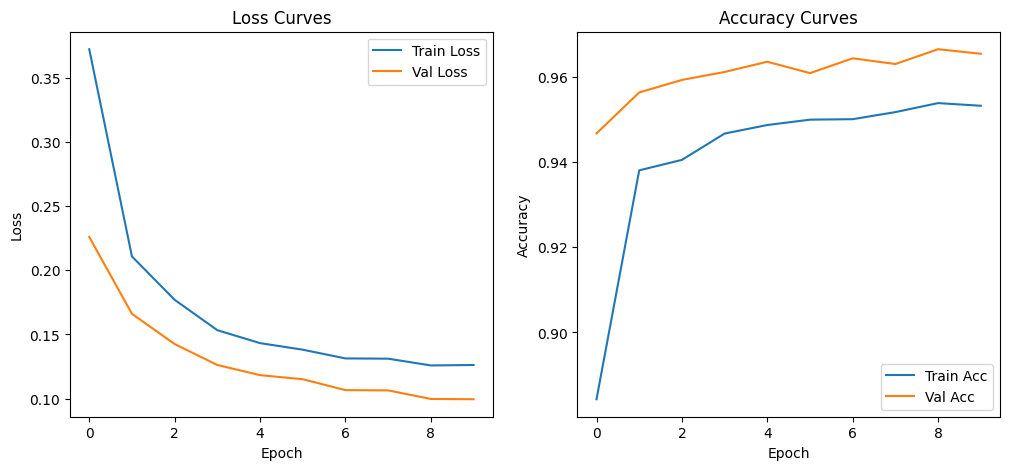

In [19]:
# Plot loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy curves
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## Occlusion Sensitivity Functions

Compute and visualize which image regions most affect model predictions.  
- `occlusion_sensitivity`: Generates a sensitivity heatmap by masking patches and measuring prediction changes.  
- `show_occlusion`: Displays the original image with the sensitivity heatmap overlay.


In [144]:
# Occlusion sensitivity function (same as yours)
def occlusion_sensitivity(model, image, label, patch_size=32):
    model.eval()
    image = image.unsqueeze(0).to(device)
    _, _, H, W = image.shape
    baseline_output = torch.softmax(model(image), dim=1)[0, label].item()
    
    sensitivity = np.zeros((H, W))
    for y in range(0, H, patch_size):
        for x in range(0, W, patch_size):
            occluded = image.clone()
            occluded[:, :, y:y+patch_size, x:x+patch_size] = 0
            output = torch.softmax(model(occluded), dim=1)[0, label].item()
            sensitivity[y:y+patch_size, x:x+patch_size] = baseline_output - output
    return sensitivity


# Visualization function
def show_occlusion(image, sensitivity, title=""):
    img = image.permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)
    
    plt.subplot(1,2,1)
    plt.title(f"{title} - Original")
    plt.imshow(img)
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.title(f"{title} - Occlusion")
    plt.imshow(img)
    plt.imshow(sensitivity, cmap="jet", alpha=0.5)
    plt.axis("off")

## Occlusion Sensitivity Visualization for Random Cat and Dog Images using EfficientNet-B0

We perform **occlusion sensitivity analysis** on a set of randomly selected images from the validation dataset, using the `efficientnet_b0` model.

**Steps performed:**
1. **Random selection:** Picks 2 cat and 2 dog images from the validation dataset.  
2. **Occlusion sensitivity computation:** Measures how occluding different regions of the image affects the model’s prediction, highlighting areas most important for classification.  
3. **Visualization:**  
    - **Left column:** Original image with the maximum sensitivity value in the title.  
    - **Right column:** Heatmap overlay showing the regions where occlusion most strongly impacts the model’s output, using a `jet` colormap.  
4. **Image normalization:** Converts images from tensor format back to RGB for proper display.  
5. **Layout:** Arranged in a 2-column grid for easy comparison of original images and their occlusion heatmaps.

This approach helps to **interpret EfficientNet-B0’s decision-making**, revealing which parts of cat and dog images are most influential in the classification.


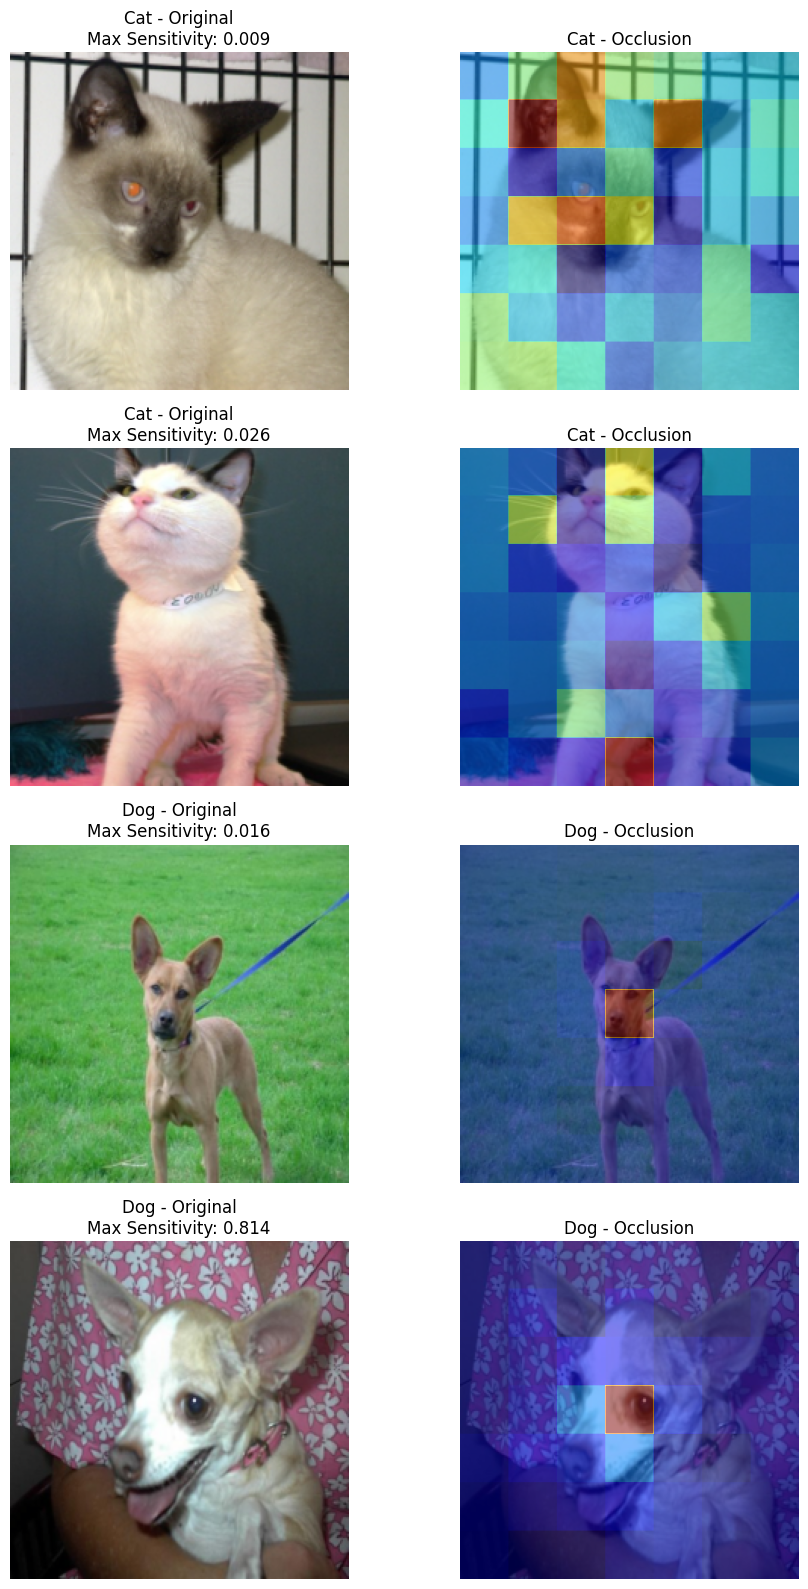

In [145]:
import random

# Pick 2 random cat and 2 random dog images

cat_indices_all = [i for i, (_, label) in enumerate(test_dataset) if label == 0]
dog_indices_all = [i for i, (_, label) in enumerate(test_dataset) if label == 1]

cat_indices = random.sample(cat_indices_all, 2)
dog_indices = random.sample(dog_indices_all, 2)
selected_indices = cat_indices + dog_indices

plt.figure(figsize=(10, 16))
for idx, sample_idx in enumerate(selected_indices):
    img, label = test_dataset[sample_idx]
    
    # Use resnet18_model for occlusion sensitivity
    sensitivity = occlusion_sensitivity(efficientnet_model, img, label)
    
    # Compute maximum sensitivity
    importance_max = sensitivity.max()
    
    # Convert image for display
    img_disp = img.permute(1, 2, 0).numpy()
    img_disp = (img_disp * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_disp = np.clip(img_disp, 0, 1)

    # Plot original with importance_max in the title
    plt.subplot(len(selected_indices), 2, 2*idx+1)
    plt.imshow(img_disp)
    plt.title(f"{'Cat' if label==0 else 'Dog'} - Original\nMax Sensitivity: {importance_max:.3f}")
    plt.axis("off")

    # Plot heatmap overlay
    plt.subplot(len(selected_indices), 2, 2*idx+2)
    plt.imshow(img_disp)
    plt.imshow(sensitivity, cmap="jet", alpha=0.5)
    plt.title(f"{'Cat' if label==0 else 'Dog'} - Occlusion")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Occlusion Sensitivity Visualization with Smoothing

We visualize occlusion sensitivity for selected images using the `efficientnet_model`.  

**Steps:**
1. Compute occlusion sensitivity heatmaps for each image.  
2. Upsample the heatmap to match the image size.  
3. Smooth the heatmap with a Gaussian filter to reduce noise.  
4. Normalize the heatmap to [0,1].  
5. Display side-by-side panels: original image and heatmap overlay (`inferno` colormap) to highlight regions most important for the model’s prediction.


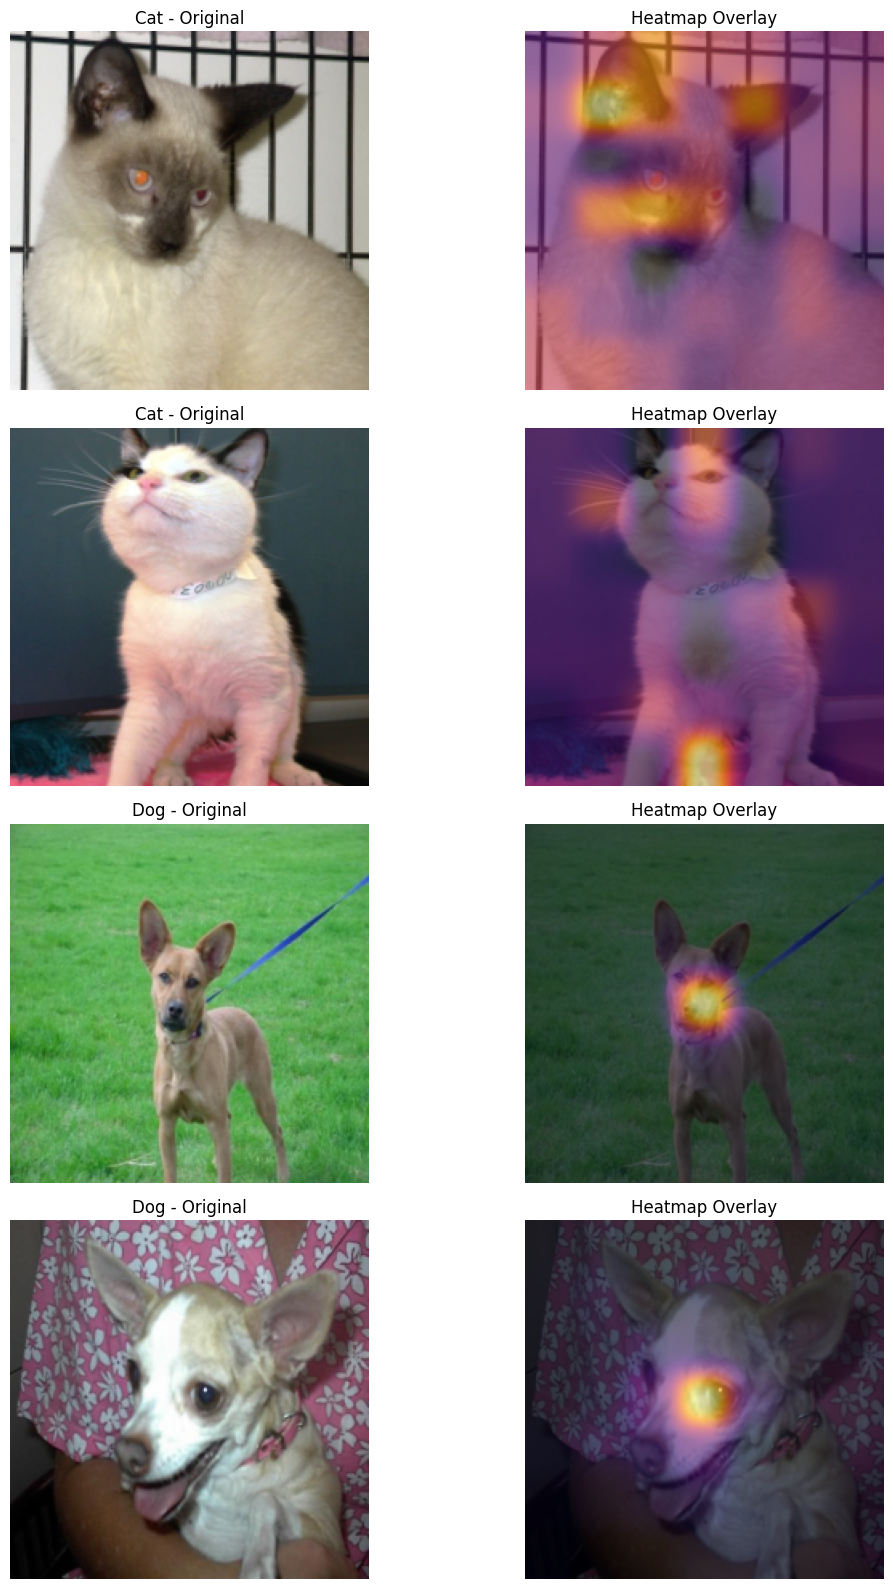

In [146]:
from scipy.ndimage import gaussian_filter
import cv2

plt.figure(figsize=(12, 4 * len(selected_indices)))

for idx, sample_idx in enumerate(selected_indices):
    img, label = test_dataset[sample_idx]
    sensitivity = occlusion_sensitivity(efficientnet_model, img, label)

    # Upsample to image size
    H, W = img.shape[1], img.shape[2]
    heatmap_resized = cv2.resize(sensitivity, (W, H))

    # Smooth the heatmap
    heatmap_smooth = gaussian_filter(heatmap_resized, sigma=7)

    # Normalize heatmap
    heatmap_norm = (heatmap_smooth - heatmap_smooth.min()) / (heatmap_smooth.max() - heatmap_smooth.min() + 1e-8)

    # Convert image for display
    img_disp = img.permute(1, 2, 0).numpy()
    img_disp = (img_disp * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_disp = np.clip(img_disp, 0, 1)

    # Panel 1: Original
    plt.subplot(len(selected_indices), 2, 2*idx+1)
    plt.imshow(img_disp)
    plt.title(f"{'Cat' if label==0 else 'Dog'} - Original")
    plt.axis("off")

    # Panel 2: Overlay 
    plt.subplot(len(selected_indices), 2, 2*idx+2)
    plt.imshow(img_disp)
    plt.imshow(heatmap_norm, cmap="inferno", alpha=0.6)
    plt.title("Heatmap Overlay")
    plt.axis("off")

plt.tight_layout()
plt.show()

# GradCAM Explainability Method

## Grad-CAM Implementation and Visualization

We define tools for **visualizing model attention** using Grad-CAM:

1. **`GradCAM` class:**  
   - Computes Grad-CAM heatmaps for a given model and target convolutional layer.  
   - Uses forward and backward hooks.  
   - Returns a normalized 2D heatmap highlighting regions important for the target class prediction.

2. **`show_gradcam_side_by_side`**  
   - Takes an image and its Grad-CAM heatmap.  
   - Converts tensor images to numpy, resizes the heatmap, applies a `jet` colormap, and overlays it on the image.  
   - Displays the **original image and the overlay side by side** for easy comparison.

3. **`show_examples_with_gradcam`**  
   - Automatically selects a number of cat and dog images from a test dataset.  
   - Computes Grad-CAM heatmaps using a provided `GradCAM` object.  
   - Displays **side-by-side comparisons** for each selected image, showing the model’s attention on each class.  
   - `num_per_class` controls how many examples per class are displayed.


In [147]:
import torch.nn.functional as F
from torch.autograd import Function
from torchvision import models

In [164]:
def show_gradcam_side_by_side(img, heatmap, alpha=0.5, title=None):
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = np.clip(img_np, 0, 1)

    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_rgb = plt.cm.jet(heatmap_resized)[:, :, :3]

    overlay = alpha * heatmap_rgb + (1 - alpha) * img_np
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM" if title is None else title)
    plt.axis("off")
    plt.show()

def show_examples_with_gradcam(model, dataset, gradcam, num_per_class=2):
    class_counts = {0: 0, 1: 0}  # 0=Cat, 1=Dog
    selected_indices = list(range(len(dataset)))
    random.shuffle(selected_indices)

    for idx in selected_indices:
        img, label = dataset[idx]
        if class_counts[label] >= num_per_class:
            continue

        # Add batch dimension and require gradients
        input_tensor = img.unsqueeze(0).to(device)
        input_tensor.requires_grad = True

        heatmap = gradcam(input_tensor, class_idx=label)
        title = "Cat" if label == 0 else "Dog"
        show_gradcam_side_by_side(img, heatmap, alpha=0.5, title=title)

        class_counts[label] += 1
        if all(count >= num_per_class for count in class_counts.values()):
            break

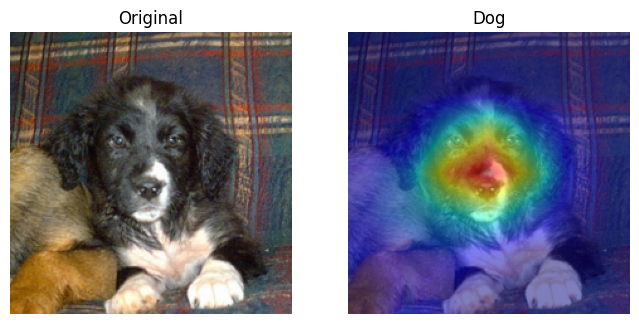

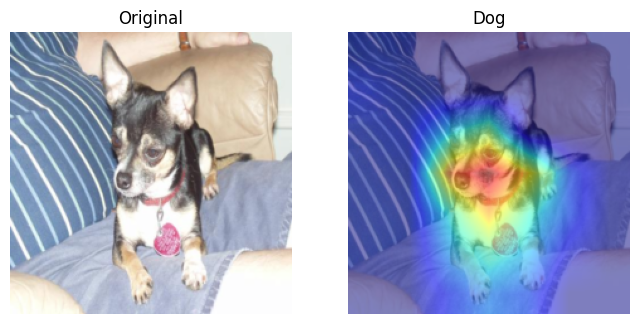

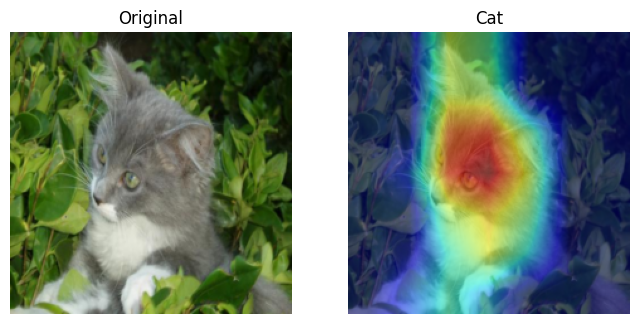

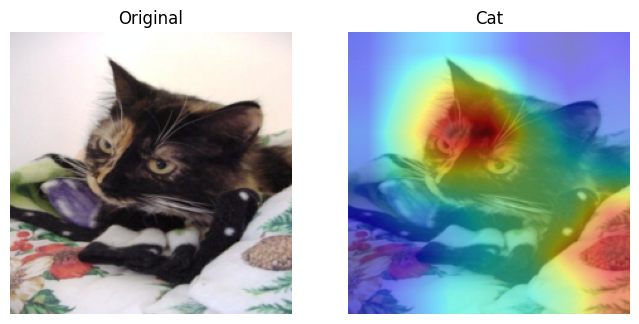

In [172]:
# Find a proper Conv2d target layer in last block
last_block = efficientnet_model.features[-1]
target_layer = None
for module in reversed(list(last_block.modules())):
    if isinstance(module, torch.nn.Conv2d):
        target_layer = module
        break

if target_layer is None:
    raise RuntimeError("No Conv2d found in last block")

# GradCAM class (kernel-safe)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Clear existing hooks
        if hasattr(self.target_layer, "_forward_hooks"):
            self.target_layer._forward_hooks.clear()
        if hasattr(self.target_layer, "_backward_hooks"):
            self.target_layer._backward_hooks.clear()

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient) 

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        if self.gradients is None or self.activations is None:
            raise RuntimeError("Gradients or activations are None.")

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# Create Grad-CAM object
gradcam = GradCAM(efficientnet_model, target_layer)

# Display examples
show_examples_with_gradcam(efficientnet_model, test_dataset, gradcam, num_per_class=2)

### Integrated Gradient Explainability Method

In [189]:
!pip install captum

In [190]:
from captum.attr import IntegratedGradients

We compute and visualize **Integrated Gradients (IG)** for the EfficientNet-B0 model:

1. **`integrated_gradients_resnet18`**  
   - Computes IG attributions for a single input image.  
   - Uses a baseline (default all zeros) and interpolates along a straight path from baseline to input.  
   - Returns a normalized attribution map and convergence delta.

2. **`show_ig_overlay`**  
   - Converts IG attributions into a 2D heatmap.  
   - Overlays the heatmap on the original image.  
   - Displays **original image and IG overlay side by side**.

3. **`show_ig_examples`**  
   - Automatically selects a number of cat and dog images from the test dataset.  
   - Computes IG attributions for each image.  
   - Displays side-by-side visualizations to highlight which regions most influence the model’s predictions.


In [192]:
# Ensure model is in eval mode

# Make sure the model is on the right device
efficientnet_model.eval()
device = next(efficientnet_model.parameters()).device

def integrated_gradients_efficientnet_model(model, input_tensor, target_label_idx, baseline=None, steps=50):
    """
    Compute Integrated Gradients for a single input on ResNet-18.

    Args:
        model: efficientnet_B0_model
        input_tensor: torch.Tensor of shape [C,H,W]
        target_label_idx: int, target class index
        baseline: torch.Tensor same shape as input_tensor, default zeros
        steps: int, number of interpolation steps

    Returns:
        attributions: numpy array, same shape as input_tensor
        delta: float, convergence delta
    """
    # Add batch dimension and send to device
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Default baseline: all zeros
    if baseline is None:
        baseline = torch.zeros_like(input_tensor).to(device)

    # Initialize Integrated Gradients
    ig = IntegratedGradients(model)

    # Compute attributions
    attributions, delta = ig.attribute(
        input_tensor,
        baselines=baseline,
        target=target_label_idx,
        n_steps=steps,
        return_convergence_delta=True
    )

    # Remove batch dimension and move to CPU
    return attributions.squeeze().detach().cpu().numpy(), delta.item()

In [202]:
def show_ig_overlay(img, attr, alpha=0.5, title=None):
    """
    Display original image and Integrated Gradients overlay side by side.

    Args:
        img: torch tensor [C,H,W] or numpy [H,W,C]
        attr: IG attributions [C,H,W] or numpy [C,H,W]
        alpha: overlay transparency
        title: optional title for overlay
    """
    # Convert image to numpy
    if torch.is_tensor(img):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
    else:
        img_np = img

    # Convert attributions to 2D heatmap
    if isinstance(attr, torch.Tensor):
        attr_np = attr.detach().cpu().numpy()
    else:
        attr_np = attr
    heatmap = np.sum(np.abs(attr_np), axis=0)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_rgb = plt.cm.jet(heatmap_resized)[:, :, :3]

    # Overlay
    overlay = heatmap_rgb * alpha + img_np * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)

    # Plot side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Integrated Gradients" if title is None else title)
    plt.axis("off")
    plt.show()

In [203]:
def show_ig_examples(model, test_dataset, num_per_class=2, steps=50):
    """
    Display original images and IG overlays for cats and dogs.

    Args:
        model: efficientnet_B0_model
        val_dataset: validation dataset of (img, label)
        num_per_class: number of images per class to display
        steps: number of steps for IG
    """
    from captum.attr import IntegratedGradients

    class_counts = {0: 0, 1: 0}  # 0=cat, 1=dog

    for img, label in test_dataset:
        if class_counts[label] >= num_per_class:
            continue

        # Compute IG
        ig = IntegratedGradients(model)
        input_tensor = img.unsqueeze(0).to(next(model.parameters()).device)
        baseline = torch.zeros_like(input_tensor)
        attr, delta = ig.attribute(input_tensor, baselines=baseline, target=label, n_steps=steps, return_convergence_delta=True)
        attr = attr.squeeze()

        # Show overlay
        title = f"Cat" if label==0 else "Dog"
        show_ig_overlay(img, attr, alpha=0.5, title=title)

        class_counts[label] += 1

        if all(count >= num_per_class for count in class_counts.values()):
            break

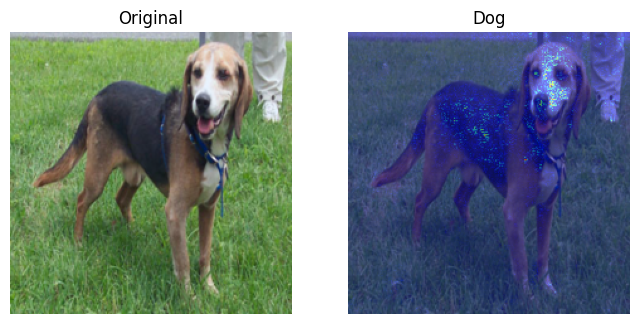

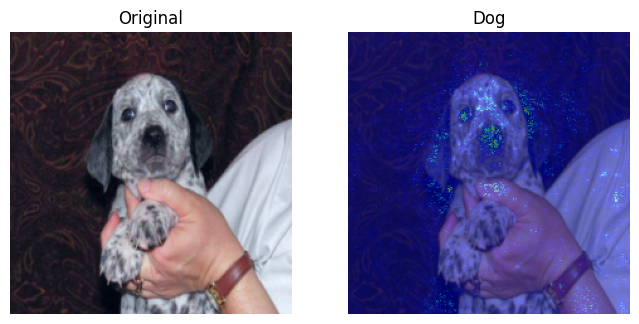

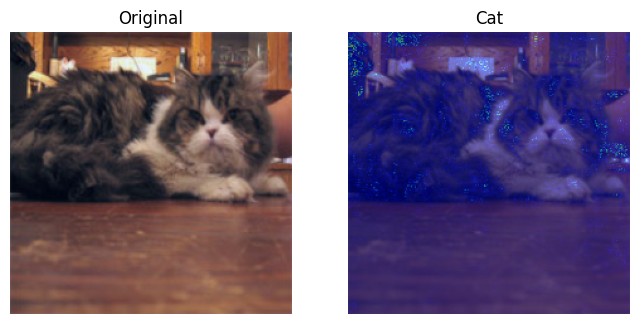

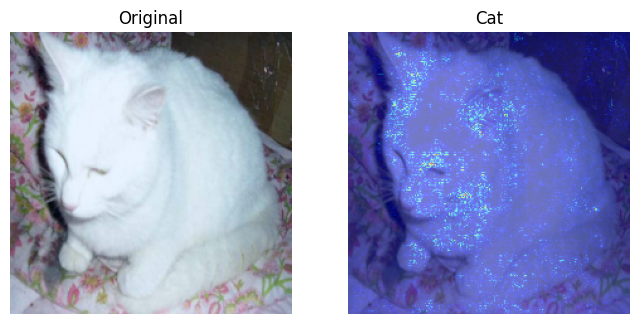

In [204]:
# Make sure the model is in eval mode
efficientnet_model.eval()

# Show 2 cats and 2 dogs with IG
show_ig_examples(efficientnet_model, test_dataset, num_per_class=2, steps=50)